In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
data_path = '/Users/andrewevans/DSI/Spring2019/SYS6016/project/Project-3-Causality/Stock data/'
data_dump = data_path+str('2017_csv/')
folders_in_path = 2017 #list(range(2017, 2018)) # list of folders (years) in data path
extension = '.zip'
folder = 2017
#for folder in folders_in_path: # for each folder (year) in data path


In [3]:
#Data extraction code
def data_extract(stock_list,data_path,folder):
    folder_path = data_path + str(folder) + '/' # path with year
    for item in os.listdir(folder_path): # loop through all zip folders in folder (year)
        if item.endswith(extension): # check for .zip extension
            file_path = folder_path + item # get full file path
            zip_files = zipfile.ZipFile(file_path) # zip obj
            zip_files_info = zip_files.infolist() # list of files inside this zip folder

            for file in zip_files_info: # for every file inside zip folder
                if file.filename in ['{}{}'.format(a, '.csv') for a in stock_list]:
                    file.filename = item[:-len(extension)] + '_' + file.filename # add the date to file name
                    zip_files.extract(file, path=data_dump) # extract all files to data folder


In [4]:
def read_data(stock_name,files, sampling_time = '15T'):
    d = pd.DataFrame()
    for file in files:
        d1 = pd.read_csv(file)
        if d1.Ticker.unique() == stock_name:
            d = pd.concat([d,d1])
    d["moddate"] = d.Date.astype('str').str[0:4] + "-" + d.Date.astype('str').str[4:6] + "-" + d.Date.astype('str').str[6:9] + " "+ d.TimeBarStart.astype('str')
    d.moddate = pd.to_datetime(d.moddate)
    d[stock_name+'_VWP'] = d.VolumeWeightPrice
    d = d[['moddate',stock_name+'_VWP']]
    d.set_index('moddate',inplace=True)
    d = d.resample('s').interpolate(method = 'time').resample(sampling_time).asfreq()
    return d

In [5]:
def reshape_data(data_dump,stock_list,aggregation_time,n_lags):
    files = glob.glob(data_dump+ '*.csv')
    db = pd.DataFrame()
    for stk in stock_list:
        a1 = read_data(stk,files,aggregation_time)
        db = pd.concat([db,a1],axis=1)
    
    #Creating lagged terms for all stocks
    lags = range(1, n_lags)

    dbm = db.assign(**{
    '{}_t_{}'.format(col, t): db[col].shift(t)
    for t in lags
    for col in db})
    
    dbm.dropna(inplace=True)
    #Reordering the dataset 
    dbm = dbm[dbm.columns[::-1]]
    #Normalizing the dataset
    dbm = pd.DataFrame(normalize(dbm, axis = 0),index = dbm.index, columns = dbm.columns)
    return dbm

In [6]:
#Specifying values for function call
stock_list = ['TWTR','FB','MSFT','AAPL']
n_lags = 15
aggregation_time = str(60) + 'T'

In [7]:
#Extracting datasets
data_extract(stock_list,data_path,folder)

In [8]:
dbm = reshape_data(data_dump,stock_list,aggregation_time,n_lags)

In [9]:
dbm.head()

,AAPL_VWP_t_14,MSFT_VWP_t_14,FB_VWP_t_14,TWTR_VWP_t_14,AAPL_VWP_t_13,MSFT_VWP_t_13,FB_VWP_t_13,TWTR_VWP_t_13,AAPL_VWP_t_12,MSFT_VWP_t_12,...,FB_VWP_t_2,TWTR_VWP_t_2,AAPL_VWP_t_1,MSFT_VWP_t_1,FB_VWP_t_1,TWTR_VWP_t_1,AAPL_VWP,MSFT_VWP,FB_VWP,TWTR_VWP
moddate,,,,,,,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.009330,0.007926,0.009827,0.008258,0.009330,0.007946,0.009876,0.008258,0.009333,...,0.007981,0.009851,0.008257,0.009302,0.007980,0.009847,0.008254,0.009279,0.007977,0.009839
2017-01-03 19:00:00,0.008258,0.009330,0.007946,0.009877,0.008258,0.009333,0.007939,0.009870,0.008267,0.009350,...,0.007980,0.009847,0.008254,0.009280,0.007978,0.009839,0.008253,0.009280,0.007972,0.009838
2017-01-03 20:00:00,0.008258,0.009334,0.007939,0.009871,0.008267,0.009351,0.007955,0.009848,0.008273,0.009342,...,0.007978,0.009840,0.008253,0.009281,0.007973,0.009838,0.008257,0.009283,0.007969,0.009829
2017-01-03 21:00:00,0.008267,0.009351,0.007956,0.009848,0.008273,0.009342,0.007944,0.009854,0.008267,0.009313,...,0.007973,0.009839,0.008257,0.009283,0.007969,0.009829,0.008259,0.009287,0.007976,0.009831
2017-01-03 22:00:00,0.008273,0.009342,0.007944,0.009855,0.008267,0.009313,0.007932,0.009803,0.008227,0.009312,...,0.007970,0.009830,0.008260,0.009288,0.007976,0.009832,0.008262,0.009292,0.007982,0.009834


In [10]:
#dbm.to_csv("tech_60m.csv")

In [11]:
twtr = dbm.filter(like='TWTR')
fb = dbm.filter(like='FB')
msft = dbm.filter(like='MSFT')
aapl = dbm.filter(like='AAPL')

#amzn['AAPL_VWP'] = dbm['AAPL_VWP']
twtr.head()

,TWTR_VWP_t_14,TWTR_VWP_t_13,TWTR_VWP_t_12,TWTR_VWP_t_11,TWTR_VWP_t_10,TWTR_VWP_t_9,TWTR_VWP_t_8,TWTR_VWP_t_7,TWTR_VWP_t_6,TWTR_VWP_t_5,TWTR_VWP_t_4,TWTR_VWP_t_3,TWTR_VWP_t_2,TWTR_VWP_t_1,TWTR_VWP
moddate,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.009827,0.009876,0.009870,0.009847,0.009852,0.009801,0.009808,0.009778,0.009759,0.009777,0.009786,0.009804,0.009851,0.009847,0.009839
2017-01-03 19:00:00,0.009877,0.009870,0.009847,0.009853,0.009801,0.009809,0.009779,0.009759,0.009778,0.009786,0.009804,0.009851,0.009847,0.009839,0.009838
2017-01-03 20:00:00,0.009871,0.009848,0.009854,0.009802,0.009809,0.009780,0.009760,0.009778,0.009787,0.009805,0.009852,0.009848,0.009840,0.009838,0.009829
2017-01-03 21:00:00,0.009848,0.009854,0.009802,0.009810,0.009780,0.009761,0.009779,0.009788,0.009805,0.009852,0.009848,0.009840,0.009839,0.009829,0.009831
2017-01-03 22:00:00,0.009855,0.009803,0.009811,0.009781,0.009761,0.009779,0.009788,0.009806,0.009853,0.009849,0.009841,0.009839,0.009830,0.009832,0.009834


In [12]:
aapl.head()

,AAPL_VWP_t_14,AAPL_VWP_t_13,AAPL_VWP_t_12,AAPL_VWP_t_11,AAPL_VWP_t_10,AAPL_VWP_t_9,AAPL_VWP_t_8,AAPL_VWP_t_7,AAPL_VWP_t_6,AAPL_VWP_t_5,AAPL_VWP_t_4,AAPL_VWP_t_3,AAPL_VWP_t_2,AAPL_VWP_t_1,AAPL_VWP
moddate,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.008258,0.008258,0.008266,0.008272,0.008266,0.008225,0.008215,0.008210,0.008216,0.008198,0.008213,0.008263,0.008257,0.008254
2017-01-03 19:00:00,0.008258,0.008258,0.008267,0.008272,0.008266,0.008226,0.008215,0.008210,0.008216,0.008199,0.008213,0.008263,0.008258,0.008254,0.008253
2017-01-03 20:00:00,0.008258,0.008267,0.008273,0.008266,0.008226,0.008216,0.008210,0.008216,0.008199,0.008214,0.008263,0.008258,0.008255,0.008253,0.008257
2017-01-03 21:00:00,0.008267,0.008273,0.008267,0.008226,0.008216,0.008211,0.008217,0.008199,0.008214,0.008264,0.008258,0.008255,0.008254,0.008257,0.008259
2017-01-03 22:00:00,0.008273,0.008267,0.008227,0.008216,0.008211,0.008217,0.008200,0.008214,0.008264,0.008259,0.008255,0.008254,0.008257,0.008260,0.008262


In [13]:
n_row = round(0.7 * dbm.shape[0])
n_row

6049

# LASSO Model Definition

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lm = Lasso(alpha = 0.0000000001)

## MSFT Predicted Alone

In [16]:
msft.shape[1]

15

In [17]:
y = msft.iloc[:,-1]
X = msft.iloc[:,:-1]

In [18]:
X.shape

(8642, 14)

In [19]:
X_train = X.iloc[:n_row,]
X_test = X.iloc[n_row:,]
y_train = y.iloc[:n_row]
y_test = y.iloc[n_row:]

In [20]:
X_train.shape

(6049, 14)

In [21]:
X_test.shape

(2593, 14)

In [22]:
lm.fit(X_train,y_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
preds = lm.predict(X_test)

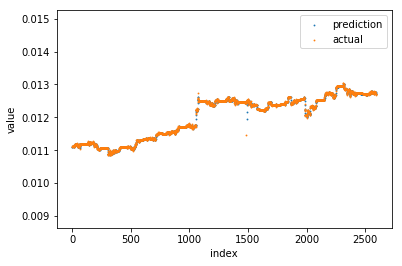

In [24]:
plt.scatter(range(len(preds)), preds, label='prediction', s = 0.7)
plt.scatter(range(len(preds)), y_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [25]:
#imp = pd.DataFrame({'variable': X.columns, 'coef': lm.coef_})
#imp.sort_values(by = 'coef')

In [26]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, preds)

1.2597151022539559e-09

## FB Predicted Alone

In [27]:
y2 = fb.iloc[:,-1]
X2 = fb.iloc[:,:-1]

In [28]:
X2.head()

,FB_VWP_t_14,FB_VWP_t_13,FB_VWP_t_12,FB_VWP_t_11,FB_VWP_t_10,FB_VWP_t_9,FB_VWP_t_8,FB_VWP_t_7,FB_VWP_t_6,FB_VWP_t_5,FB_VWP_t_4,FB_VWP_t_3,FB_VWP_t_2,FB_VWP_t_1
moddate,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.007926,0.007946,0.007939,0.007955,0.007943,0.007931,0.007985,0.008011,0.007973,0.007980,0.007958,0.007962,0.007981,0.007980
2017-01-03 19:00:00,0.007946,0.007939,0.007955,0.007943,0.007931,0.007986,0.008011,0.007974,0.007980,0.007958,0.007962,0.007981,0.007980,0.007978
2017-01-03 20:00:00,0.007939,0.007955,0.007943,0.007932,0.007986,0.008012,0.007974,0.007981,0.007959,0.007963,0.007981,0.007980,0.007978,0.007973
2017-01-03 21:00:00,0.007956,0.007944,0.007932,0.007986,0.008012,0.007974,0.007981,0.007959,0.007963,0.007982,0.007981,0.007978,0.007973,0.007969
2017-01-03 22:00:00,0.007944,0.007932,0.007987,0.008012,0.007975,0.007981,0.007959,0.007963,0.007982,0.007981,0.007979,0.007973,0.007970,0.007976


In [29]:
X2_train = X2.iloc[:n_row,:]
X2_test = X2.iloc[n_row:,]
y2_train = y2.iloc[:n_row]
y2_test = y2.iloc[n_row:]

In [30]:
lm2 = Lasso(alpha = 0.0000000001)
lm2.fit(X2_train,y2_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
preds2 = lm2.predict(X2_test)

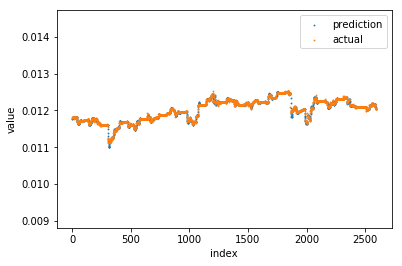

In [32]:
plt.scatter(range(len(preds2)), preds2, label='prediction', s = 0.7)
plt.scatter(range(len(preds2)), y2_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [33]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y2_test, preds2)

1.2070945293416841e-09

In [34]:
#imp2 = pd.DataFrame({'variable': X2.columns, 'coef': lm2.coef_})
#imp2.sort_values(by = 'coef')

# TWTR predicted alone

In [35]:
y3 = twtr.iloc[:,-1]
X3 = twtr.iloc[:,:-1]

In [36]:
X3.head()

,TWTR_VWP_t_14,TWTR_VWP_t_13,TWTR_VWP_t_12,TWTR_VWP_t_11,TWTR_VWP_t_10,TWTR_VWP_t_9,TWTR_VWP_t_8,TWTR_VWP_t_7,TWTR_VWP_t_6,TWTR_VWP_t_5,TWTR_VWP_t_4,TWTR_VWP_t_3,TWTR_VWP_t_2,TWTR_VWP_t_1
moddate,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.009827,0.009876,0.009870,0.009847,0.009852,0.009801,0.009808,0.009778,0.009759,0.009777,0.009786,0.009804,0.009851,0.009847
2017-01-03 19:00:00,0.009877,0.009870,0.009847,0.009853,0.009801,0.009809,0.009779,0.009759,0.009778,0.009786,0.009804,0.009851,0.009847,0.009839
2017-01-03 20:00:00,0.009871,0.009848,0.009854,0.009802,0.009809,0.009780,0.009760,0.009778,0.009787,0.009805,0.009852,0.009848,0.009840,0.009838
2017-01-03 21:00:00,0.009848,0.009854,0.009802,0.009810,0.009780,0.009761,0.009779,0.009788,0.009805,0.009852,0.009848,0.009840,0.009839,0.009829
2017-01-03 22:00:00,0.009855,0.009803,0.009811,0.009781,0.009761,0.009779,0.009788,0.009806,0.009853,0.009849,0.009841,0.009839,0.009830,0.009832


In [37]:
X3_train = X3.iloc[:n_row,:]
X3_test = X3.iloc[n_row:,]
y3_train = y3.iloc[:n_row]
y3_test = y3.iloc[n_row:]

In [38]:
lm3 = Lasso(alpha = 0.0000001)
lm3.fit(X3_train,y3_train)

Lasso(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
preds3 = lm3.predict(X3_test)

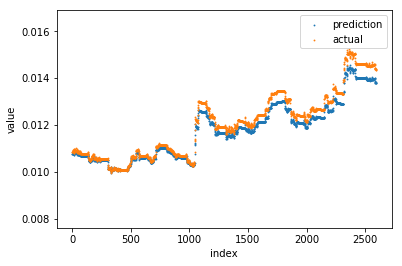

In [40]:
plt.scatter(range(len(preds3)), preds3, label='prediction', s = 0.7)
plt.scatter(range(len(preds3)), y3_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [41]:
imp3 = pd.DataFrame({'variable': X3.columns, 'coef': lm3.coef_})
imp3.sort_values(by = 'coef')

,variable,coef
0,TWTR_VWP_t_14,0.000000
1,TWTR_VWP_t_13,0.000000
2,TWTR_VWP_t_12,0.000000
3,TWTR_VWP_t_11,0.000000
4,TWTR_VWP_t_10,0.000000
5,TWTR_VWP_t_9,0.000000
6,TWTR_VWP_t_8,0.000000
7,TWTR_VWP_t_7,0.000000
8,TWTR_VWP_t_6,0.000000
9,TWTR_VWP_t_5,0.000000


In [42]:
mean_squared_error(y3_test, preds3)

1.0294429345984937e-07

# AAPL predicted alone

In [43]:
y4 = aapl.iloc[:,-1]
X4 = aapl.iloc[:,:-1]

In [44]:
X4.head()

,AAPL_VWP_t_14,AAPL_VWP_t_13,AAPL_VWP_t_12,AAPL_VWP_t_11,AAPL_VWP_t_10,AAPL_VWP_t_9,AAPL_VWP_t_8,AAPL_VWP_t_7,AAPL_VWP_t_6,AAPL_VWP_t_5,AAPL_VWP_t_4,AAPL_VWP_t_3,AAPL_VWP_t_2,AAPL_VWP_t_1
moddate,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.008258,0.008258,0.008266,0.008272,0.008266,0.008225,0.008215,0.008210,0.008216,0.008198,0.008213,0.008263,0.008257
2017-01-03 19:00:00,0.008258,0.008258,0.008267,0.008272,0.008266,0.008226,0.008215,0.008210,0.008216,0.008199,0.008213,0.008263,0.008258,0.008254
2017-01-03 20:00:00,0.008258,0.008267,0.008273,0.008266,0.008226,0.008216,0.008210,0.008216,0.008199,0.008214,0.008263,0.008258,0.008255,0.008253
2017-01-03 21:00:00,0.008267,0.008273,0.008267,0.008226,0.008216,0.008211,0.008217,0.008199,0.008214,0.008264,0.008258,0.008255,0.008254,0.008257
2017-01-03 22:00:00,0.008273,0.008267,0.008227,0.008216,0.008211,0.008217,0.008200,0.008214,0.008264,0.008259,0.008255,0.008254,0.008257,0.008260


In [45]:
X4_train = X4.iloc[:n_row,:]
X4_test = X4.iloc[n_row:,]
y4_train = y4.iloc[:n_row]
y4_test = y4.iloc[n_row:]

In [46]:
lm4 = Lasso(alpha = 0.00000001)
lm4.fit(X4_train,y4_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
preds4 = lm4.predict(X4_test)

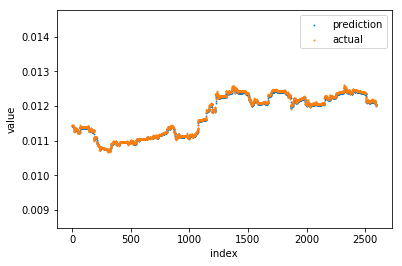

In [48]:
plt.scatter(range(len(preds4)), preds4, label='prediction', s = 0.7)
plt.scatter(range(len(preds4)), y4_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [49]:
#imp3 = pd.DataFrame({'variable': X3.columns, 'coef': lm3.coef_})
#imp3.sort_values(by = 'coef')

In [50]:
mean_squared_error(y4_test, preds4)

1.1540431709495981e-09

# Predict MSFT with additional stocks

In [51]:
y5 = msft.iloc[:,-1]
X5 = dbm.iloc[:,:-4]

In [52]:
X5.head()

,AAPL_VWP_t_14,MSFT_VWP_t_14,FB_VWP_t_14,TWTR_VWP_t_14,AAPL_VWP_t_13,MSFT_VWP_t_13,FB_VWP_t_13,TWTR_VWP_t_13,AAPL_VWP_t_12,MSFT_VWP_t_12,...,FB_VWP_t_3,TWTR_VWP_t_3,AAPL_VWP_t_2,MSFT_VWP_t_2,FB_VWP_t_2,TWTR_VWP_t_2,AAPL_VWP_t_1,MSFT_VWP_t_1,FB_VWP_t_1,TWTR_VWP_t_1
moddate,,,,,,,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.009330,0.007926,0.009827,0.008258,0.009330,0.007946,0.009876,0.008258,0.009333,...,0.007962,0.009804,0.008263,0.009306,0.007981,0.009851,0.008257,0.009302,0.007980,0.009847
2017-01-03 19:00:00,0.008258,0.009330,0.007946,0.009877,0.008258,0.009333,0.007939,0.009870,0.008267,0.009350,...,0.007981,0.009851,0.008258,0.009303,0.007980,0.009847,0.008254,0.009280,0.007978,0.009839
2017-01-03 20:00:00,0.008258,0.009334,0.007939,0.009871,0.008267,0.009351,0.007955,0.009848,0.008273,0.009342,...,0.007980,0.009848,0.008255,0.009280,0.007978,0.009840,0.008253,0.009281,0.007973,0.009838
2017-01-03 21:00:00,0.008267,0.009351,0.007956,0.009848,0.008273,0.009342,0.007944,0.009854,0.008267,0.009313,...,0.007978,0.009840,0.008254,0.009281,0.007973,0.009839,0.008257,0.009283,0.007969,0.009829
2017-01-03 22:00:00,0.008273,0.009342,0.007944,0.009855,0.008267,0.009313,0.007932,0.009803,0.008227,0.009312,...,0.007973,0.009839,0.008257,0.009284,0.007970,0.009830,0.008260,0.009288,0.007976,0.009832


In [53]:
X5_train = X5.iloc[:n_row,:]
X5_test = X5.iloc[n_row:,]
y5_train = y5.iloc[:n_row]
y5_test = y5.iloc[n_row:]

In [54]:
lm5 = Lasso(alpha = 0.00000001)
lm5.fit(X5_train,y5_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
preds5 = lm5.predict(X5_test)

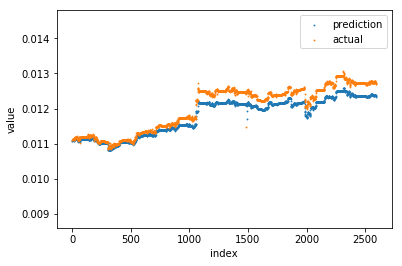

In [56]:
plt.scatter(range(len(preds5)), preds5, label='prediction', s = 0.7)
plt.scatter(range(len(preds5)), y5_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [57]:
imp5 = pd.DataFrame({'variable': X5.columns, 'coef': lm5.coef_})
imp5.sort_values(by = 'coef')

,variable,coef
0,AAPL_VWP_t_14,0.000000
26,FB_VWP_t_8,0.000000
28,AAPL_VWP_t_7,0.000000
29,MSFT_VWP_t_7,0.000000
30,FB_VWP_t_7,0.000000
31,TWTR_VWP_t_7,0.000000
32,AAPL_VWP_t_6,0.000000
33,MSFT_VWP_t_6,0.000000
34,FB_VWP_t_6,0.000000
35,TWTR_VWP_t_6,0.000000


In [58]:
mean_squared_error(y5_test, preds5), mean_squared_error(y_test, preds)

(7.213961445962745e-08, 1.2597151022539559e-09)

# Predict FB with additional stocks

In [59]:
y6 = fb.iloc[:,-1]
X6 = dbm.iloc[:,:-4]

In [60]:
X6.head()

,AAPL_VWP_t_14,MSFT_VWP_t_14,FB_VWP_t_14,TWTR_VWP_t_14,AAPL_VWP_t_13,MSFT_VWP_t_13,FB_VWP_t_13,TWTR_VWP_t_13,AAPL_VWP_t_12,MSFT_VWP_t_12,...,FB_VWP_t_3,TWTR_VWP_t_3,AAPL_VWP_t_2,MSFT_VWP_t_2,FB_VWP_t_2,TWTR_VWP_t_2,AAPL_VWP_t_1,MSFT_VWP_t_1,FB_VWP_t_1,TWTR_VWP_t_1
moddate,,,,,,,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.009330,0.007926,0.009827,0.008258,0.009330,0.007946,0.009876,0.008258,0.009333,...,0.007962,0.009804,0.008263,0.009306,0.007981,0.009851,0.008257,0.009302,0.007980,0.009847
2017-01-03 19:00:00,0.008258,0.009330,0.007946,0.009877,0.008258,0.009333,0.007939,0.009870,0.008267,0.009350,...,0.007981,0.009851,0.008258,0.009303,0.007980,0.009847,0.008254,0.009280,0.007978,0.009839
2017-01-03 20:00:00,0.008258,0.009334,0.007939,0.009871,0.008267,0.009351,0.007955,0.009848,0.008273,0.009342,...,0.007980,0.009848,0.008255,0.009280,0.007978,0.009840,0.008253,0.009281,0.007973,0.009838
2017-01-03 21:00:00,0.008267,0.009351,0.007956,0.009848,0.008273,0.009342,0.007944,0.009854,0.008267,0.009313,...,0.007978,0.009840,0.008254,0.009281,0.007973,0.009839,0.008257,0.009283,0.007969,0.009829
2017-01-03 22:00:00,0.008273,0.009342,0.007944,0.009855,0.008267,0.009313,0.007932,0.009803,0.008227,0.009312,...,0.007973,0.009839,0.008257,0.009284,0.007970,0.009830,0.008260,0.009288,0.007976,0.009832


In [61]:
X6_train = X6.iloc[:n_row,:]
X6_test = X6.iloc[n_row:,]
y6_train = y6.iloc[:n_row]
y6_test = y6.iloc[n_row:]

In [62]:
lm6 = Lasso(alpha = 0.00000001)
lm6.fit(X6_train,y6_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
preds6 = lm6.predict(X6_test)

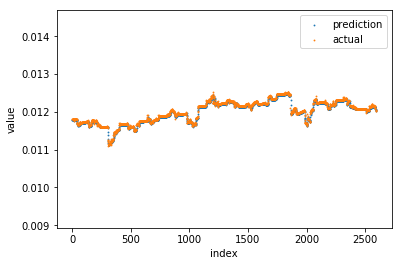

In [64]:
plt.scatter(range(len(preds6)), preds6, label='prediction', s = 0.7)
plt.scatter(range(len(preds6)), y6_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [65]:
mean_squared_error(y6_test, preds6), mean_squared_error(y2_test, preds2)

(1.349968497360264e-09, 1.2070945293416841e-09)

# Predict TWTR with additional stocks

In [66]:
y7 = twtr.iloc[:,-1]
X7 = dbm.iloc[:,:-4]

In [67]:
X7.head()

,AAPL_VWP_t_14,MSFT_VWP_t_14,FB_VWP_t_14,TWTR_VWP_t_14,AAPL_VWP_t_13,MSFT_VWP_t_13,FB_VWP_t_13,TWTR_VWP_t_13,AAPL_VWP_t_12,MSFT_VWP_t_12,...,FB_VWP_t_3,TWTR_VWP_t_3,AAPL_VWP_t_2,MSFT_VWP_t_2,FB_VWP_t_2,TWTR_VWP_t_2,AAPL_VWP_t_1,MSFT_VWP_t_1,FB_VWP_t_1,TWTR_VWP_t_1
moddate,,,,,,,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.009330,0.007926,0.009827,0.008258,0.009330,0.007946,0.009876,0.008258,0.009333,...,0.007962,0.009804,0.008263,0.009306,0.007981,0.009851,0.008257,0.009302,0.007980,0.009847
2017-01-03 19:00:00,0.008258,0.009330,0.007946,0.009877,0.008258,0.009333,0.007939,0.009870,0.008267,0.009350,...,0.007981,0.009851,0.008258,0.009303,0.007980,0.009847,0.008254,0.009280,0.007978,0.009839
2017-01-03 20:00:00,0.008258,0.009334,0.007939,0.009871,0.008267,0.009351,0.007955,0.009848,0.008273,0.009342,...,0.007980,0.009848,0.008255,0.009280,0.007978,0.009840,0.008253,0.009281,0.007973,0.009838
2017-01-03 21:00:00,0.008267,0.009351,0.007956,0.009848,0.008273,0.009342,0.007944,0.009854,0.008267,0.009313,...,0.007978,0.009840,0.008254,0.009281,0.007973,0.009839,0.008257,0.009283,0.007969,0.009829
2017-01-03 22:00:00,0.008273,0.009342,0.007944,0.009855,0.008267,0.009313,0.007932,0.009803,0.008227,0.009312,...,0.007973,0.009839,0.008257,0.009284,0.007970,0.009830,0.008260,0.009288,0.007976,0.009832


In [68]:
X7_train = X7.iloc[:n_row,:]
X7_test = X7.iloc[n_row:,]
y7_train = y7.iloc[:n_row]
y7_test = y7.iloc[n_row:]

In [69]:
lm7 = Lasso(alpha = 0.00000001)
lm7.fit(X7_train,y7_train)

Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
preds7 = lm7.predict(X7_test)

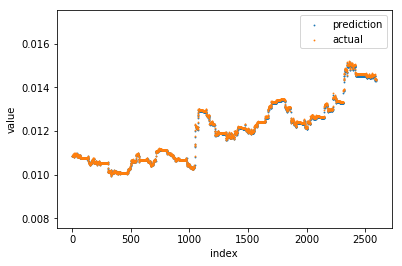

In [71]:
plt.scatter(range(len(preds7)), preds7, label='prediction', s = 0.7)
plt.scatter(range(len(preds7)), y7_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [72]:
#imp3 = pd.DataFrame({'variable': X3.columns, 'coef': lm3.coef_})
#imp3.sort_values(by = 'coef')

In [73]:
mean_squared_error(y7_test, preds7), mean_squared_error(y3_test, preds3)

(3.446933556294465e-09, 1.0294429345984937e-07)

# Predict AAPL with additional stocks

In [74]:
y8 = aapl.iloc[:,-1]
X8 = dbm.iloc[:,:-4]

In [75]:
X8.head()

,AAPL_VWP_t_14,MSFT_VWP_t_14,FB_VWP_t_14,TWTR_VWP_t_14,AAPL_VWP_t_13,MSFT_VWP_t_13,FB_VWP_t_13,TWTR_VWP_t_13,AAPL_VWP_t_12,MSFT_VWP_t_12,...,FB_VWP_t_3,TWTR_VWP_t_3,AAPL_VWP_t_2,MSFT_VWP_t_2,FB_VWP_t_2,TWTR_VWP_t_2,AAPL_VWP_t_1,MSFT_VWP_t_1,FB_VWP_t_1,TWTR_VWP_t_1
moddate,,,,,,,,,,,,,,,,,,,,,
2017-01-03 18:00:00,0.008251,0.009330,0.007926,0.009827,0.008258,0.009330,0.007946,0.009876,0.008258,0.009333,...,0.007962,0.009804,0.008263,0.009306,0.007981,0.009851,0.008257,0.009302,0.007980,0.009847
2017-01-03 19:00:00,0.008258,0.009330,0.007946,0.009877,0.008258,0.009333,0.007939,0.009870,0.008267,0.009350,...,0.007981,0.009851,0.008258,0.009303,0.007980,0.009847,0.008254,0.009280,0.007978,0.009839
2017-01-03 20:00:00,0.008258,0.009334,0.007939,0.009871,0.008267,0.009351,0.007955,0.009848,0.008273,0.009342,...,0.007980,0.009848,0.008255,0.009280,0.007978,0.009840,0.008253,0.009281,0.007973,0.009838
2017-01-03 21:00:00,0.008267,0.009351,0.007956,0.009848,0.008273,0.009342,0.007944,0.009854,0.008267,0.009313,...,0.007978,0.009840,0.008254,0.009281,0.007973,0.009839,0.008257,0.009283,0.007969,0.009829
2017-01-03 22:00:00,0.008273,0.009342,0.007944,0.009855,0.008267,0.009313,0.007932,0.009803,0.008227,0.009312,...,0.007973,0.009839,0.008257,0.009284,0.007970,0.009830,0.008260,0.009288,0.007976,0.009832


In [76]:
X8_train = X8.iloc[:n_row,:]
X8_test = X8.iloc[n_row:,]
y8_train = y8.iloc[:n_row]
y8_test = y8.iloc[n_row:]

In [77]:
lm8 = Lasso(alpha = 0.00000001)
lm8.fit(X8_train,y8_train)

/anaconda3/envs/tfenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
preds8 = lm8.predict(X8_test)

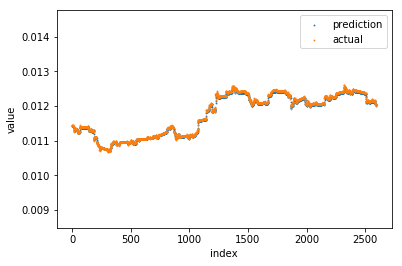

In [79]:
plt.scatter(range(len(preds8)), preds8, label='prediction', s = 0.7)
plt.scatter(range(len(preds8)), y8_test,  label='actual', s = 0.7)
plt.xlabel('index')
plt.ylabel('value')
plt.legend(loc='best')

In [80]:
imp3 = pd.DataFrame({'variable': X8.columns, 'coef': lm8.coef_})
imp3.sort_values(by = 'coef')

,variable,coef
0,AAPL_VWP_t_14,0.000000
54,FB_VWP_t_1,0.000000
28,AAPL_VWP_t_7,0.000000
29,MSFT_VWP_t_7,0.000000
30,FB_VWP_t_7,0.000000
31,TWTR_VWP_t_7,0.000000
32,AAPL_VWP_t_6,0.000000
33,MSFT_VWP_t_6,0.000000
34,FB_VWP_t_6,0.000000
35,TWTR_VWP_t_6,0.000000


In [81]:
mean_squared_error(y8_test, preds8), mean_squared_error(y4_test, preds4)

(1.1296045478411969e-09, 1.1540431709495981e-09)